# Explanatory Data Analysis

In [124]:
from pathlib import Path
import json
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
data_path = Path.cwd().parent / 'data'

In [15]:
for file in data_path.glob('*'):
    print(file.name)

enefit
.DS_Store
client.csv
weather_station_to_county_mapping.csv
gas_prices.csv
forecast_weather.csv
electricity_prices.csv
example_test_files
county_id_to_name_map.json
public_timeseries_testing_util.py
train.csv
historical_weather.csv


In [18]:
def load_file(file_name, data_path=data_path, file_extension='csv'):
    filepath = data_path / (file_name + '.' + file_extension)
    if file_extension == 'csv':
        return pd.read_csv(filepath)
    elif file_extension == 'json':
        with open(filepath) as json_file:
            file = json.load(json_file)
        return file
    else:
        raise ValueError('Wrong `file_extension` argument')

In [63]:
def plot_hist(series, bins=50):
    plt.figure(figsize=(12, 6))
    plt.hist(series, edgecolor='black', bins=bins)
    plt.show()

In [112]:
def plot_category_distribution(cat_counts, x=None):
    if x is None:
        x = cat_counts.index
    plt.figure(figsize=(12, 8))
    sns.barplot(x=x, y=cat_counts.values, hue=cat_counts.index, palette='Blues_d', legend=False)
    plt.plot('Distribution of categories')
    plt.xlabel('Category')
    plt.xticks(rotation=30, ha='right')
    for i, v in enumerate(cat_counts):
        plt.text(i, v + 1000, str(v), ha='center')
    plt.show()

In [126]:
def plot_boxplot(data, x, y):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=x, y=y, data=data)
    plt.show()

## 1. Train

In [141]:
train = load_file('train')

In [61]:
train.head(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
5,0,0,3,656.859,1,2021-09-01 00:00:00,0,5,2
6,0,1,0,0.000,0,2021-09-01 00:00:00,0,6,3
7,0,1,0,59.000,1,2021-09-01 00:00:00,0,7,3
8,0,1,1,0.000,0,2021-09-01 00:00:00,0,8,4
9,0,1,1,501.760,1,2021-09-01 00:00:00,0,9,4


Columns explaination:
* **county** - An ID code for the county.
* **is_business** - Boolean for whether or not the prosumer is a business.
* **product_type** - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
* ***target*** - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
* **is_consumption** - Boolean for whether or not this row's target is consumption or production.
* **datetime** - The Estonian time in EET (UTC+2) / EEST (UTC+3). It describes the start of the 1-hour period on which target is given.
* **data_block_id** - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
* **row_id** - A unique identifier for the row.
* **prediction_unit_id** - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.

In [24]:
train.shape

(2018352, 9)

In [25]:
train.dtypes

county                  int64
is_business             int64
product_type            int64
target                float64
is_consumption          int64
datetime               object
data_block_id           int64
row_id                  int64
prediction_unit_id      int64
dtype: object

In [44]:
train.isna().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [59]:
train.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


### 1.1 county

In [27]:
train['county'].unique()
# we have 15 counties in dataset

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [28]:
county_map_json = load_file('county_id_to_name_map', file_extension='json')

In [100]:
county_map_json = {int(k): v for k, v in county_map_json.items()}

In [101]:
county_distribution = train['county'].value_counts()
#imbalanced counties
county_distribution = county_distribution.rename(index=county_map_json)
county_distribution

county
HARJUMAA         212928
TARTUMAA         198000
PÄRNUMAA         173088
LÄÄNE-VIRUMAA    151632
VÕRUMAA          148752
JÕGEVAMAA        147264
SAAREMAA         134640
VILJANDIMAA      125808
JÄRVAMAA         122496
RAPLAMAA         122496
VALGAMAA         121056
IDA-VIRUMAA      115200
HIIUMAA           91872
PÕLVAMAA          91872
LÄÄNEMAA          30624
UNKNOWN           30624
Name: count, dtype: int64

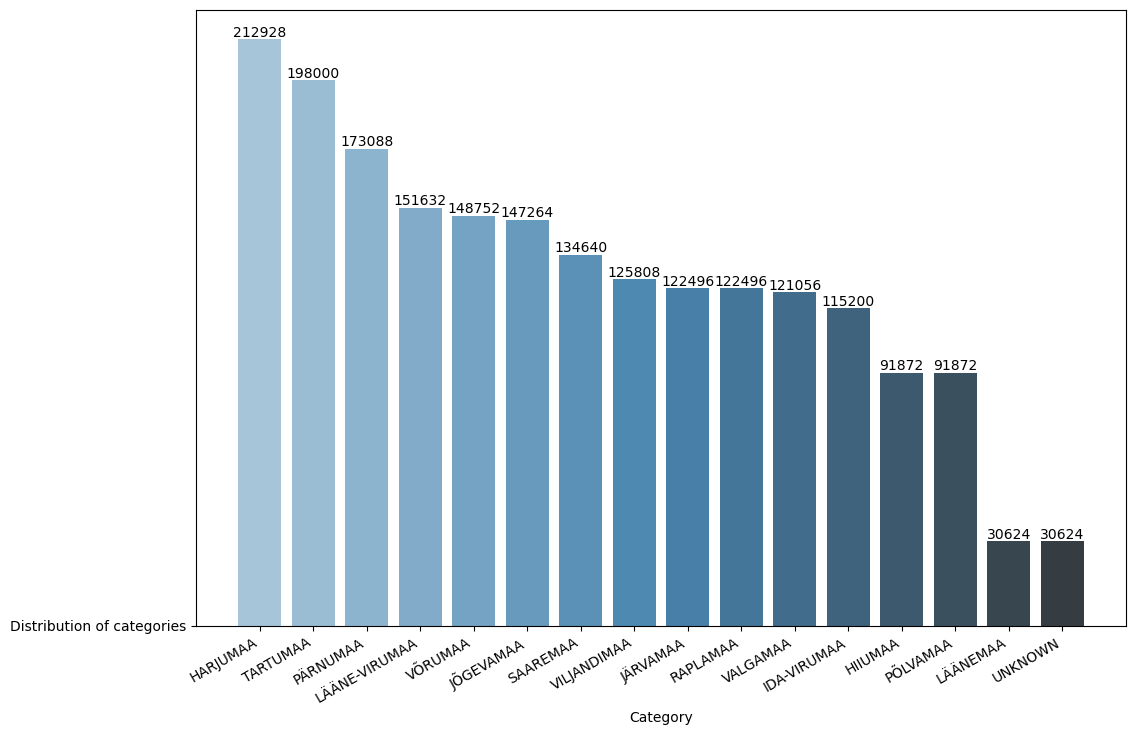

In [113]:
plot_category_distribution(county_distribution)

In [72]:
# there is 'Unknown' county (id=12)

### 1.2. is_business

In [39]:
train['is_business'].value_counts()
# ~53.6% of all prosumers are businesses

is_business
1    1083504
0     934848
Name: count, dtype: int64

### 1.3 product_type

In [117]:
product_type_distribution = train['product_type'].value_counts()
product_type_dict = {
    3: 'Spot',
    2: 'Fixed',
    1: 'Combined',
    0: 'General service'
}
product_type_distribution = product_type_distribution.rename(index=product_type_dict)
# as follows: Spot, Fixed, Combined, General service

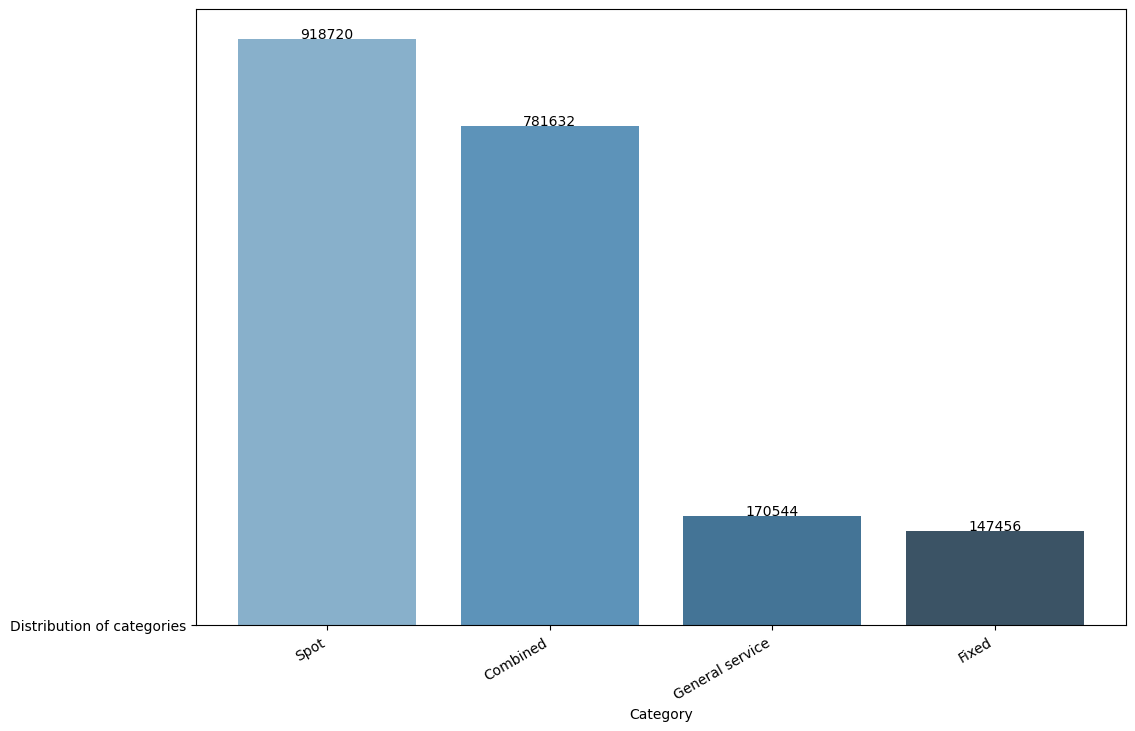

In [118]:
plot_category_distribution(product_type_distribution)

### 1.4 target

In [57]:
# there is 528 NaNs

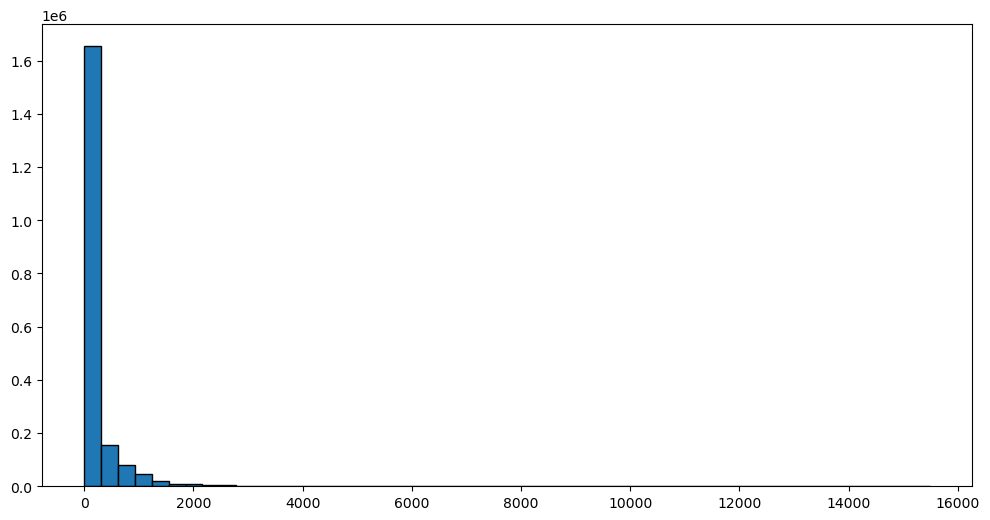

In [68]:
plot_hist(train['target'])

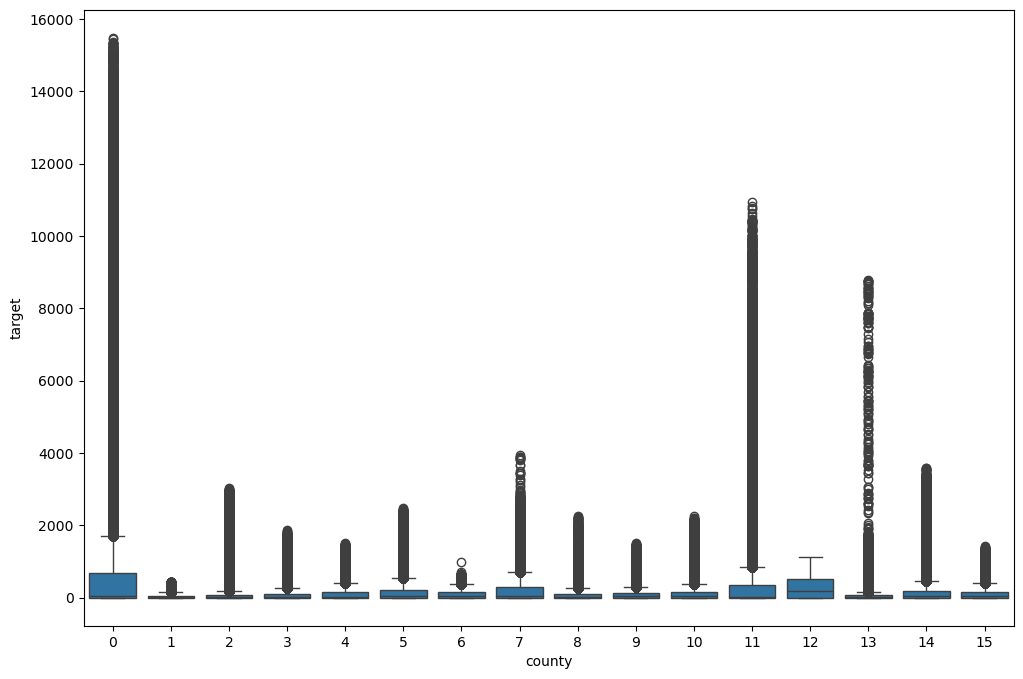

In [127]:
plot_boxplot(x='county', y='target', data=train)

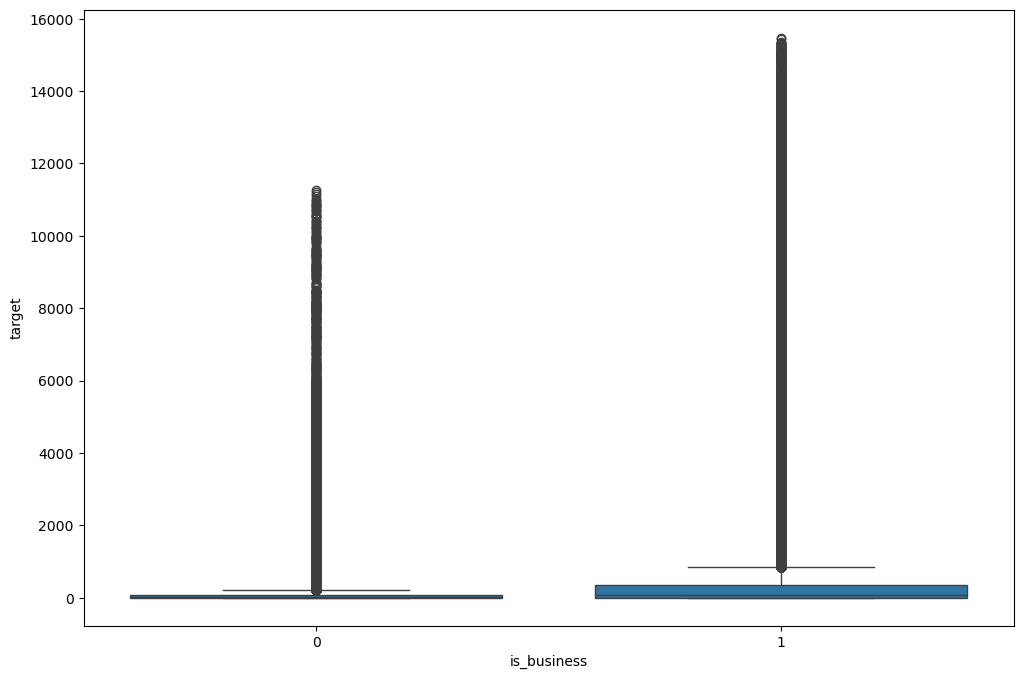

In [129]:
plot_boxplot(x='is_business', y='target', data=train)

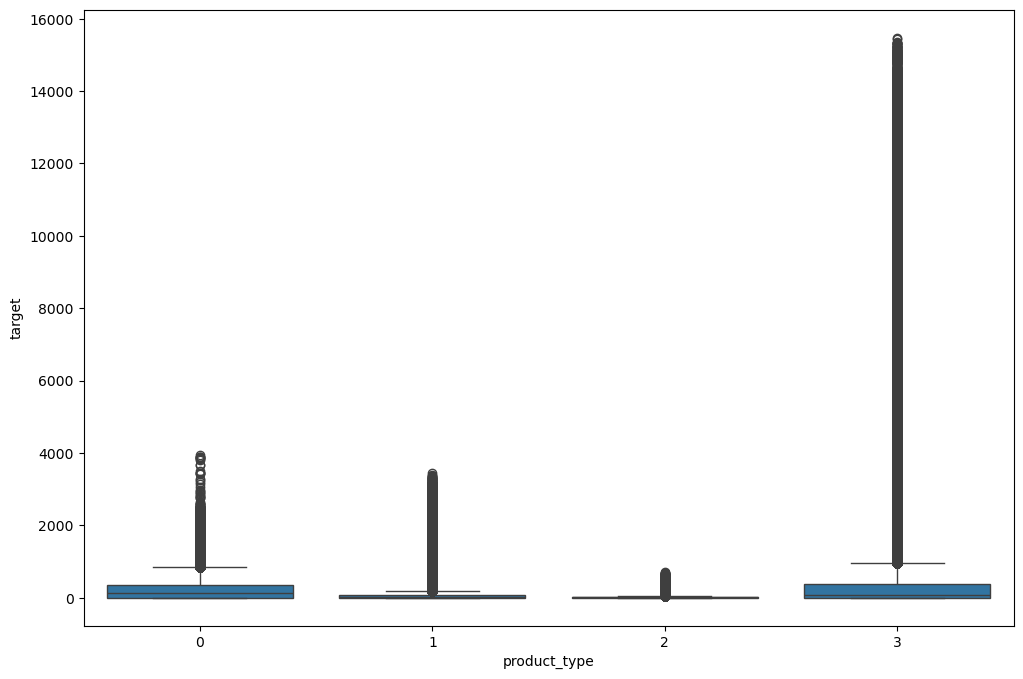

In [130]:
plot_boxplot(x='product_type', y='target', data=train)

In [131]:
# The highest values (outliers) for county 0 (HARJUMAA), business prosumer and Spot contract type

### 1.5. is_consumption

In [132]:
train['is_consumption'].value_counts()  # 50 / 50 consumption vs production

is_consumption
0    1009176
1    1009176
Name: count, dtype: int64

### 1.6 datetime

In [149]:
train['datetime']

0         2021-09-01 00:00:00
1         2021-09-01 00:00:00
2         2021-09-01 00:00:00
3         2021-09-01 00:00:00
4         2021-09-01 00:00:00
                  ...        
2018347   2023-05-31 23:00:00
2018348   2023-05-31 23:00:00
2018349   2023-05-31 23:00:00
2018350   2023-05-31 23:00:00
2018351   2023-05-31 23:00:00
Name: datetime, Length: 2018352, dtype: datetime64[ns]

In [151]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['datetime'] = train['datetime'].dt.tz_localize('Europe/Tallinn', ambiguous='NaT', nonexistent='NaT')
# it should be later filled

In [152]:
train['datetime']

0         2021-09-01 00:00:00+03:00
1         2021-09-01 00:00:00+03:00
2         2021-09-01 00:00:00+03:00
3         2021-09-01 00:00:00+03:00
4         2021-09-01 00:00:00+03:00
                     ...           
2018347   2023-05-31 23:00:00+03:00
2018348   2023-05-31 23:00:00+03:00
2018349   2023-05-31 23:00:00+03:00
2018350   2023-05-31 23:00:00+03:00
2018351   2023-05-31 23:00:00+03:00
Name: datetime, Length: 2018352, dtype: datetime64[ns, Europe/Tallinn]